# Generating the dataset from the pdb

In [1]:
from src.data_prep import run, get_id_and_ressolution, augment_dataset, get_all_files_and_ids, download_all_pdbs
from src.dataset import AminoAcidDataset
from torch.utils.data import DataLoader
import json
import matplotlib.pyplot as plt
import os

## 1. Downloading and extracting resolution information from the PDBs

In [2]:
# Downlaod 
# download_all_pdbs("data/all_pdbs")

In [3]:
# Extract the saved pdb file paths and ids
pdb_files, pdb_ids = get_all_files_and_ids()
print(f"Found {len(pdb_files)} PDB files")

subset_ids = pdb_ids[:10000]
subset_files = pdb_files[:10000]

pdb_resolution = get_id_and_ressolution(subset_ids, subset_files, batch_size=40)


Found 38574 PDB files


Of the 10000 PDB files, 9117 have a resolution value
Considering only files with a resolution of less than 6, we have 9046 files


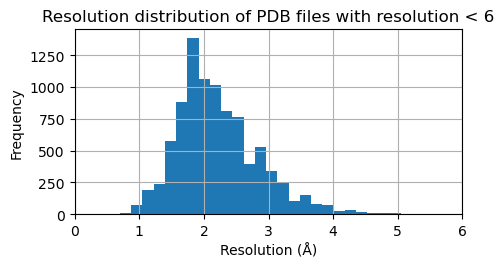

In [4]:
print(f"Of the {len(pdb_resolution)} PDB files, {len([k for k, v in pdb_resolution.items() if v is not None])} have a resolution value")
print(f"Considering only files with a resolution of less than 6, we have {len([k for k, v in pdb_resolution.items() if v is not None and v < 6])} files")

plotable_dict = {k: v for k, v in pdb_resolution.items() if v is not None and v < 6}
plt.figure(figsize=(5,2.4))
plt.hist(plotable_dict.values(), bins=30)
plt.xlim(0,6)
plt.xlabel("Resolution (Å)")
plt.ylabel("Frequency")
plt.title("Resolution distribution of PDB files with resolution < 6")
plt.grid()
plt.show()

## 2. Extracting all amino acids from the PDB-files and sorting datasets with different resolutions

In [ ]:
# Extract all amino acids at a ressolution cutoff and save to file
def get_all_amino_acids_with_resolution(target_resolution, output_path):
    """Get all amino acids from pdb files with a resolution less than target_resolution and save to output_path

    Args:
        target_resolution (float): The target resolution
        output_path (str): The path to save the amino acids to

    Returns:
        None
    """

    # Get the pdb ids with a resolution of less than target_resolution
    pdb_ids = {k: v for k, v in pdb_resolution.items() if v is not None and v < target_resolution}
    # Get all pdb files where the file name contains any of the pdbids
    pdb_files = [f for f in subset_files if any(p.upper() in f.upper() for p in pdb_ids)]
    # Get the amino acids from the pdb files
    pdb_info = [*zip(pdb_ids, pdb_files)]
    # Run the amino acid extraction and save to file
    print(f"Extracting amino acids with resolution < {target_resolution} from {len(pdb_info)} PDB files")
    run(pdb_info=pdb_info, out_path=output_path ,download=True)

# res cutoff 2.0
get_all_amino_acids_with_resolution(2.0, 'data/amino_acids_2_0A.pdb')

# res cutoff 1.5
get_all_amino_acids_with_resolution(1.5, 'data/amino_acids_1_5A.pdb')


Extracting amino acids with resolution < 2.0 from 3694 PDB files


## 3. Processing and augmenting the dataset

Here we use go through 2 steps:
1. We load the amino acid dataset with, raw extracted amino acids from the file
2. We apply processing to these amino acids:
   - In the first step the amino acids are centered at the origin
   - In the second step if n_orientations > 1, we will apply random transformations to the residue and save n copies of the residue to augment the data.

In [ ]:
# Load the Dataset and create a torch Dataloader
dataset = AminoAcidDataset('data/amino_acids_2_0A.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
# Now we process the dataset using the augment_dataset function
augment_dataset(dataset, 'data/amino_acids_2_0A_augmented.pdb',2)

# Now for the 1.5 Å dataset
dataset = AminoAcidDataset('data/amino_acids_1.5A_augmented.pdb')
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
augment_dataset(dataset, 'data/amino_acids_1.5A_augmented.pdb',2)